# Flight cancellation predictions
   ### Study by  Junaid Shaikh

The airline delays and cancellations every year significantly impact both airlines and their passengers. According to an estimate, only airline delays cost $22 billions annually to the airlines. The delays and cancellations also affect negatively on the capacity of airports as well on the goodwill of airline passengers. To be able to reduce the impact of such events and devise better and timely actions, prediction of delays and cancellations are important to airlines, airports and passengers.

In this work, I am initiating a short study on the prediction of airline cancellations and present some preliminary insights based on a US airline dataset available on the following link: 
http://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236&DB_Short_Name=On-Time

My insights are based on the data of 19 months (from 01/2015 to 07/2016). The dataset is very interesting. The problem became interesting as study progressed. However, This report is unfortunately limited to the study of only a few aspects. There are several aspects which could be explored further. I will discuss them further at the end of this report.




### References
[1] https://books.google.se/books?id=4yOeWfX5gekC&pg=PA16&redir_esc=y#v=onepage&q&f=false

## Data Exploration

The dataset consists of 9.09 million rows. The number of variables are limited to 37, which are listed below. This means that there were 9.09 million flights between 1 Jan 2015 to 31 July 2016. These flights belong to 14 airline companies and connected passengers between 323 airports within the US. A total of 5061 tail numbers were used for 9.09 million flights. 

*The tail number is the aircraft registration number. Tail numbers are useful (among other things) for tracking private aircraft and non-scheduled charter flights. 

In [456]:
import pandas as pd
import numpy as np
import matplotlib
import pickle
import json
import forecastio
from dateutil import rrule
from datetime import datetime, timedelta
import forecastio
import getpass
from dateutil.relativedelta import relativedelta
from sklearn import linear_model
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score


In [ ]:
raw_data = pd.read_pickle("raw_data.pkl")

In [459]:
print raw_data.shape
for col in raw_data.columns:
    print col


(9098999, 39)
YEAR
QUARTER
MONTH
DAY_OF_MONTH
DAY_OF_WEEK
UNIQUE_CARRIER
AIRLINE_ID
TAIL_NUM
FL_NUM
ORIGIN
DEST
CRS_DEP_TIME
DEP_TIME
DEP_DELAY
TAXI_OUT
WHEELS_OFF
WHEELS_ON
TAXI_IN
CRS_ARR_TIME
ARR_TIME
ARR_DELAY
CANCELLED
CANCELLATION_CODE
DIVERTED
CRS_ELAPSED_TIME
ACTUAL_ELAPSED_TIME
AIR_TIME
FLIGHTS
DISTANCE
CARRIER_DELAY
WEATHER_DELAY
NAS_DELAY
SECURITY_DELAY
LATE_AIRCRAFT_DELAY
TOTAL_ADD_GTIME
LONGEST_ADD_GTIME
Unnamed: 36
CRS_DEP_TIME_HOUR
CRS_ARR_TIME_HOUR


### Carriers

In [460]:
print "Number of unique airline IDs:",len(raw_data["AIRLINE_ID"].unique())
print "Unique carriers:", raw_data["UNIQUE_CARRIER"].unique()
print "Number of unique tail numbers:", len(raw_data["TAIL_NUM"].unique())
print raw_data["TAIL_NUM"].head(5)
print raw_data["FL_NUM"].head(5)
print raw_data["FLIGHTS"].head(5)
print "Number of unique number of flights:", len(raw_data["FLIGHTS"].unique())

Number of unique airline IDs: 14
Unique carriers: ['UA' 'OO' 'US' 'VX' 'WN' 'AA' 'AS' 'B6' 'DL' 'EV' 'F9' 'HA' 'MQ' 'NK']
Number of unique tail numbers: 5061
0    N768UA
1    N211UA
2    N469UA
3    N802UA
4    N529UA
Name: TAIL_NUM, dtype: object
0    218
1    219
2    220
3    220
4    221
Name: FL_NUM, dtype: int64
0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: FLIGHTS, dtype: float64
Number of unique number of flights: 1


### Airports

In [461]:
print "Number of unique origin airports:",len(raw_data["ORIGIN"].unique())
print "Number of unique destination airports:",len(raw_data["DEST"].unique())
print "Airport examples:", raw_data["ORIGIN"].head(5)

Number of unique origin airports: 323
Number of unique destination airports: 322
Airport examples: 0    HNL
1    ORD
2    ORD
3    PIT
4    IAD
Name: ORIGIN, dtype: object


## Airline performance factors

The data suggest that there are several different factors that may affect the airline performance. These factors may broadly be categorised into temporal, spatial and environmental factors. In this study, mainly these three dimensions are further taken into account. First we will take a brief look at the airline performance. 

### Performance 
The performance of flights can be analysed from three perspective:

* Time delays
* Cancellations  
* Diversions

According to Federal Aviation Administration (FAA), the flights which are delayed more than 15 minutes from their scheduled time are considered "delayed" flights. Similarly, the airlines which do not fly at all from their respective origins are considered "cancelled" flights.

We will now study cancelled flights in this dataset.

### Flight cancellations
A total of 9098999 flights were scheduled between 2015/01/01 and 2016/07/31. Among these flights, 134014 flights were cancelled. This makes a cancellation rate of 1.4%. Among cancelled flights, 54.1% were cancelled due to weather reasons, according to data. 28.2% flights were cancelled due to carrier, 17.5% due to National Airspace System (NAS) and only 0.01% were cancelled due to the security reasons.

A => Carrier ; B => Weather ; C => NAS; D => Security

In [462]:
print "Total number of flights:", raw_data['CANCELLED'].count()
print "Normal and cancelled flights:"
print raw_data['CANCELLED'].value_counts()
print raw_data['CANCELLATION_CODE'].value_counts()
print raw_data['CANCELLATION_CODE'].value_counts()/134014


Total number of flights: 9098999
Normal and cancelled flights:
0.0    8964985
1.0     134014
Name: CANCELLED, dtype: int64
B    72504
A    37915
C    23571
D       24
Name: CANCELLATION_CODE, dtype: int64
B    0.541018
A    0.282918
C    0.175885
D    0.000179
Name: CANCELLATION_CODE, dtype: float64


### Cancellation ratio by time

Cancellation ratio is higher on Mondays (2.06%) as compared to the other days of week. The cancellation ratio is lowest on Fridays. Months of January and February are relatively more prone to flight cancellations. The ratio of cancelled flights go over 3% in February. December, June and July are the other main candidates for most flight cancellations. Higher cancellations in January and February can be intuitively attributed to bad weather in these winter months in North America. Cancellations in December, June and July may be explained by extra load and lack of resources due to vacation and tourism periods.

Moreover, in terms of time of day, cancellations are relatively higher at a few selected hours in a day, e.g., in the evenings between 18 to 21 when the cancellations are 1.8% or above. Similarly, cancellation ratio appears to be high at 2 am in the morning, which is quite surprising. Bad weather or poor visibility could be a probable cause behind such delays. However, the cancellation ratio seems to dive sharply after 2 am. 

1-7 => Monday - Sunday



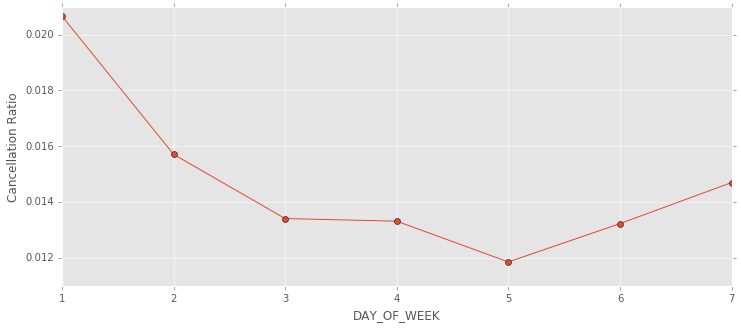

In [463]:
%matplotlib inline
matplotlib.style.use('ggplot')
ax = raw_data.groupby('DAY_OF_WEEK')['CANCELLED'].agg("mean").plot(style='-o', grid=1, xticks=np.arange(1,8,1), figsize=(12,5),label='Cancellatio Ratio')
ax.set_ylabel("Cancellation Ratio")

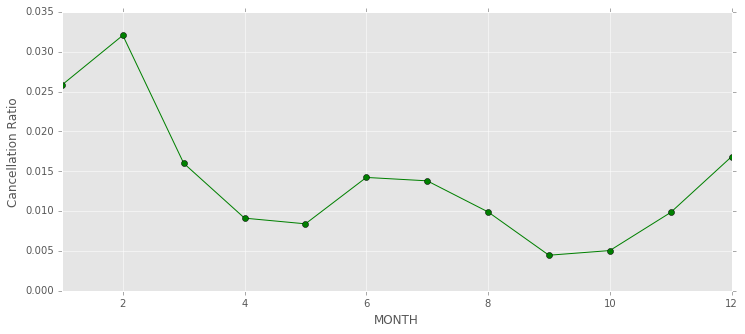

In [464]:
ax = raw_data.groupby('MONTH')['CANCELLED'].agg("mean").plot(style='-o', label = 'CD scale',grid=1, figsize=(12,5),color='g')
ax.set_ylabel("Cancellation Ratio")

In [465]:
import numpy as np
raw_data["CRS_DEP_TIME_HOUR"] = (raw_data["CRS_DEP_TIME"]/100).apply(np.floor).astype(int)
raw_data["CRS_ARR_TIME_HOUR"] = (raw_data["CRS_ARR_TIME"]/100).apply(np.floor).astype(int)

In [466]:
raw_data[["CRS_DEP_TIME","CRS_DEP_TIME_HOUR","CRS_ARR_TIME","CRS_ARR_TIME_HOUR"]].head(10)

,CRS_DEP_TIME,CRS_DEP_TIME_HOUR,CRS_ARR_TIME,CRS_ARR_TIME_HOUR
0,1550,15,506,5
1,905,9,1309,13
2,2055,20,2347,23
3,1717,17,1755,17
4,823,8,927,9
5,2015,20,2316,23
6,1205,12,1709,17
7,900,9,1144,11
8,1805,18,1935,19
9,2059,20,2358,23


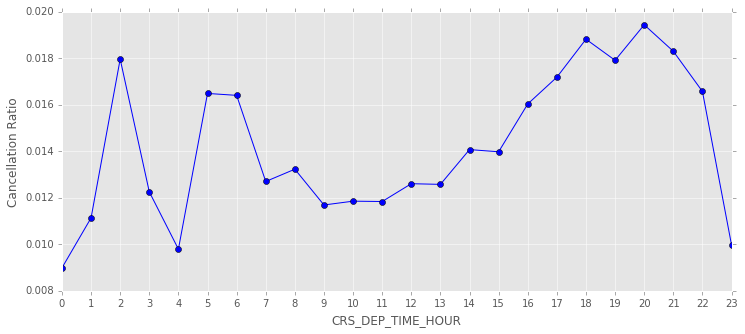

In [467]:
#raw_data.groupby('CRS_DEP_TIME_HOUR')['CANCELLED'].agg("mean").plot(figsize=(15,5))
ax =  raw_data.groupby('CRS_DEP_TIME_HOUR')['CANCELLED'].agg("mean").plot(color = 'b',grid=1, style='-o', xticks=np.arange(0,24,1), figsize=(12,5))
ax.set_ylabel("Cancellation Ratio")

### Cancellation ratio by carrier

Let's look at the cancellation ratio by carriers. The cancellations very quite a lot across carriers (upto 10 fold). From 5% to less than 0.4%. The potential reason is that carriers with very high cancellatio ratio are not very top-tier passenger carriers. 


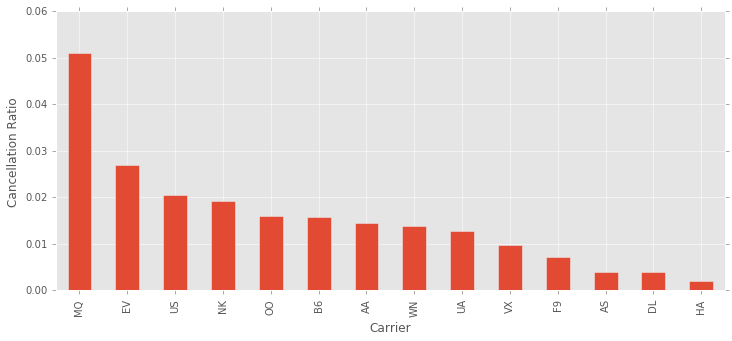

In [468]:
ax = raw_data.groupby('UNIQUE_CARRIER')['CANCELLED'].agg("mean").sort_values(ascending=0).plot(kind = 'bar',figsize=(12,5))
ax.set_ylabel("Cancellation Ratio")
ax.set_xlabel("Carrier")

### Cancellations by airport
There are 323 airports. The following bar plot shows top 20% origin airports by cancellation ratio. The cancellation ratio for these airports is above 2% and usually below 10%. However, the ratio is even above 15% for one airport (MMH). The potential reason behind high cancellation ratio could be that these airports are not very popular airports. Therefore, generally there are very few airlines that fly from these airports. Therefore, we need to look at the absolute number of cancelled flights. 

The number of cancelled flights show that the popular airports are among the top airports by absolute number of flight cancellations. Chicago o'Hare Domestic (ORD) airport, which is among one of the most popular airports tops the list of most cancelled flights.


#### Top 64 (~20%) airports w.r.t cancellation ratio of flight

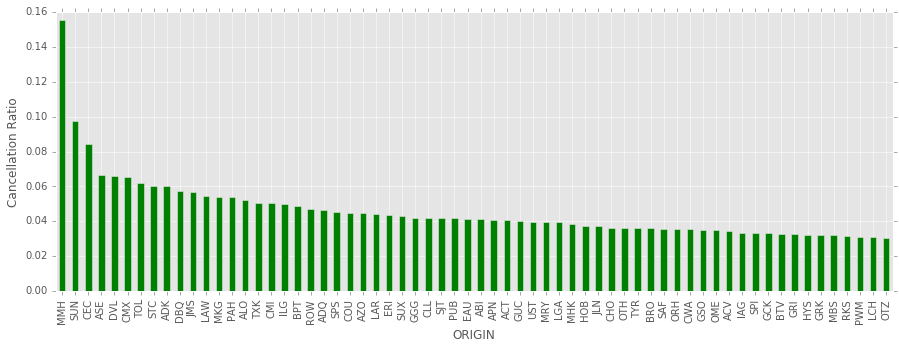

In [469]:
ax = raw_data.groupby('ORIGIN')['CANCELLED'].agg("mean").sort_values(ascending=0)[:64].plot(kind = 'bar',figsize=(15,5), color ='g')
ax.set_ylabel("Cancellation Ratio")

#### Top 64 (~20%) airports w.r.t cancellation numbers of flight

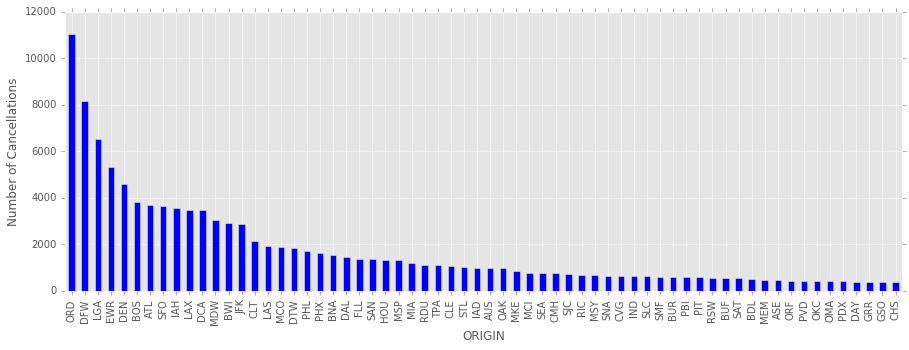

In [470]:
ax = raw_data.groupby('ORIGIN')['CANCELLED'].agg("sum").sort_values(ascending=0)[:64].plot(kind = 'bar',figsize=(15,5), color ='b')
ax.set_ylabel("Number of Cancellations")

In [471]:
temp = raw_data.groupby('ORIGIN')['CANCELLED'].value_counts()
temp

ORIGIN  CANCELLED
ABE     0.0           3836
        1.0             63
ABI     0.0           2452
        1.0            105
ABQ     0.0          31498
        1.0            328
ABR     0.0           1154
        1.0             14
ABY     0.0           1542
        1.0             10
ACK     0.0            848
        1.0             10
ACT     0.0           2534
        1.0            108
ACV     0.0           2181
        1.0             78
ACY     0.0           5954
        1.0            105
ADK     0.0            156
        1.0             10
ADQ     0.0            761
        1.0             37
AEX     0.0           4894
        1.0            118
AGS     0.0           4086
        1.0             28
AKN     0.0            120
ALB     0.0          13568
        1.0            180
ALO     0.0            639
                     ...  
TUL     1.0            348
TUS     0.0          25590
        1.0            265
TVC     0.0           4149
        1.0            126
TWF     0.

In [472]:
temp_2 = pd.DataFrame(temp)
temp_2 = temp_2.rename(columns={"CANCELLED":"COUNTS"}) 
temp_2 = temp_2.reset_index(level=['ORIGIN','CANCELLED'])
temp_2 = pd.pivot_table(temp_2,index=["ORIGIN"],columns=["CANCELLED"],values=["COUNTS"])


#### Top 25 airports w.r.t cancellation numbers along with non-cancelled flights

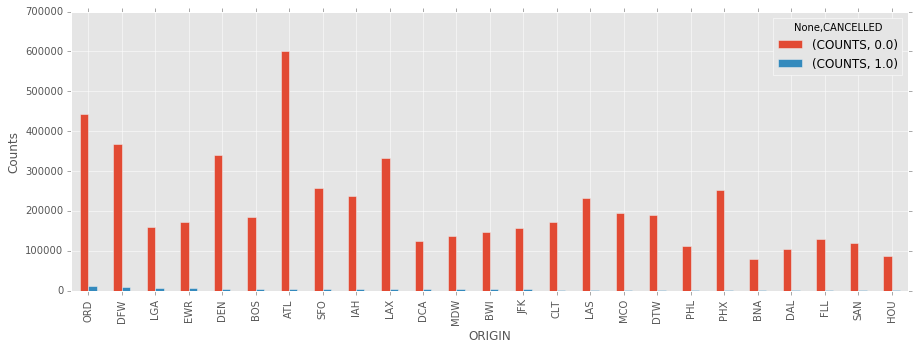

In [473]:
temp_2['COUNTS'][1] 
ax = temp_2.sort_values([('COUNTS',1)], ascending=0)[:25].plot(kind="bar",figsize=(15,5))
ax.set_ylabel("Counts")

## Problem formulation

As described at the start of this report that the main aim of this study is to develop a model that can help in the prediction of cancelled flights. However, this raises further practical questions:

* What should model exactly predict? 

   - Should we Predict if a flight will be cancelled or not? (Binary classification problem) OR
   
   - Should we Predict of number of cancellations within a certain interval? (Regression problem)

In this study we will stick to the former one, i.e. the binary classification problem.

* How far in advance before the original flight departure time should the prediction be made in number of hours?

This can be decided based on evaluation of model with different number of hours. However, due to time limitation, in this report predictions are made 3 hours in advance. The 3 hours time limit is chosen based on the fact that domestic passengers usually arrive at airports less than 3 hours before departure time. Similarly gate allotment to flights at airport is done around 3 hours before departure time.

Thus, if T_d  is the original departure time, T_p = (T_d - 3 hours) is the prediction time. 
   

## Feature extraction 

In this study, feature extraction is performed in three areas based on the exploration of data:

* Carrier-related features
* Airport-related features
* Weather-related features
* Temporal features
* Cancellations of carrier and origin in the recent time 

Cancellation in recent time can be done by time-windowing and estimating the numbers. To perform time-windowing per origin, destination and carrier level, I briefly switch to the Spark dataframes. The spark time window functions are quite nice (inherited from SQL) and help perform operations on timewindows in fast and easy way. (copy my script from Appache Zeppelin here)



In [ ]:
from pyspark.sql.window import Window
import pyspark.sql.functions as func
import math
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

raw_data_spark_df = sqlc.createDataFrame(raw_data)

### windowing according to carrier, origin and destination 
## Time window length: 2 hours i.e. T_p - 2hrs  to T_p

windowSpec_carrier = Window.partitionBy(raw_data_spark_df['UNIQUE_CARRIER']).orderBy(raw_data_1_df['CRS_DEP_EPOCH_TS'].asc())
cancelled_flights = func.sum(raw_data_spark_df['CANCELLED']).over(windowSpec_carrier.rangeBetween(-18000, -7200))

windowSpec_origin = Window.partitionBy(raw_data_spark_df['ORIGIN']).orderBy(raw_data_spark_df['CRS_DEP_EPOCH_TS'].asc())
cancelled_flights_origin = func.sum(rraw_data_spark_df['CANCELLED']).over(windowSpec_origin.rangeBetween(-18000, -7200))

windowSpec_dest = Window.partitionBy(raw_data_spark_df['DEST']).orderBy(raw_data_spark_df['CRS_DEP_EPOCH_TS'].asc())
cancelled_flights_dest = func.sum(raw_data_spark_df['CANCELLED']).over(windowSpec_dest.rangeBetween(-18000, -7200))

windowed_data = raw_data_spark_df.select("*",cancelled_flights.alias("CARRIER_CANCELLED"),cancelled_flights_origin.alias("ORIGIN_CANCELLED"),cancelled_flights_dest.alias("DEST_CANCELLED"))

windowed_data_features = windowed_data.select("YEAR","MONTH","DAY_OF_MONTH","DAY_OF_WEEK","UNIQUE_CARRIER",
                                              "TAIL_NUM","ORIGIN","DEST","CRS_ELAPSED_TIME","DISTANCE",
                                              "CRS_DEP_TIME_HOUR","CRS_ARR_TIME_HOUR","CARRIER_CANCELLED",
                                              "ORIGIN_CANCELLED","DEST_CANCELLED","CANCELLED")







In [ ]:
### Indexing of string-related features (to have numeric data). 
# Columns used for indexing: "UNIQUE_CARRIER","TAIL_NUM","ORIGIN","DEST"
indexers_flight = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(test_features_1) for column in ["UNIQUE_CARRIER","TAIL_NUM","ORIGIN","DEST"]]

pipeline_flight = Pipeline(stages=indexers_flight)
flight_features_1_indexed = pipeline_flight.fit(windowed_data_features).transform(windowed_data_features)

## Model development and evaluation (Rough & Quick)

Now we may move on to the model development and evaluation process. To be able to keep up with time, I am reducing the dataset to only one origin airport, i.e, the model development will be done for flights departing from only one airport in the US. As we saw previously that Chicago ORD airport has highest cancellation ratio (2.4%) among the popular airports, we will reduce our dataset to flights with ORD airport as origin. 

Although, ORD airport has higher cancellation ratio among popular airports, the cancellation ratio of 2.4% is still quite low for a binary classification problem. The rarety of cancellation events make this highly class-imbalanced problem with a large number (97.8% 0s) of non-cancelled flights as compared to cancelled flights (2.4% 1s). Hence, we will have to take lot of caution while evaluating our model


In [476]:
## returning back from spark DF, now we have pandas DF at hand: flight_features_1_indexed_ord_2_pd
print flight_features_1_indexed_ord_2_pd.shape
flight_features_1_indexed_ord_2_pd.head(5)



(455117, 17)


,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,CRS_DEP_TIME_HOUR,CRS_ARR_TIME_HOUR,UNIQUE_CARRIER_index,TAIL_NUM_index,ORIGIN_index,ORIGIN_CANCELLED,DEST_index,DISTANCE,DEST_CANCELLED,CARRIER_CANCELLED,CANCELLED,EPOCH_TS,EPOCH_TS_PRED
0,2015,1,1,4,5,9,10.0,1233.0,1.0,0.0,21.0,1182.0,0.0,0.0,0.0,1.420110e+09,1.420099e+09
1,2015,1,1,4,5,9,10.0,1304.0,1.0,0.0,17.0,733.0,0.0,0.0,0.0,1.420110e+09,1.420099e+09
2,2015,1,1,4,5,8,6.0,679.0,1.0,0.0,13.0,867.0,0.0,0.0,0.0,1.420110e+09,1.420099e+09
3,2015,1,1,4,5,7,5.0,2918.0,1.0,0.0,3.0,888.0,0.0,19.0,0.0,1.420110e+09,1.420099e+09
4,2015,1,1,4,5,8,5.0,3719.0,1.0,0.0,7.0,925.0,0.0,19.0,0.0,1.420110e+09,1.420099e+09


In these work, I have limited the model development to:
* Linear Regression
* Logistic Regression
* K Nearest Neighbors (KNN)
* Random Forest

I wanted to test xgboost and SVM too but due to time limitation, I am limiting the evaluations to the above algorithms. 
Just to have quick idea, the evaluations are limited to only one run to save time. This may however, make the models biased towards the splits between training and validation samples.

I played around little bit with the different parameters within the above models, however, there was no dramatic differences due to the parameters.

For evaluations, 80% samples are randomly selected for training and 20% for the validation. This may potentially create information leakage problem as samples are evluated independent of time. However, just to have sneakpeak at model performance, I stick to random evaluation. Later, I will show some evaluations by splitting training and test samples keeping timeline in mind.

The below first round of model development and evaluation shows that Random Forest (RF) model outperforms other models (which is not surprising in this case). However, the accuracy of predicting cancelled flights is still not very high. Particularly Recall score for cancelled flights is very low. The highest recall score is 0.40, which we achieve using RF with 50 trees. F1-score for RF is however above 50%. r2_score is relatively higher in RF model.

This shows that class imbalance problem has a large influence on the model. The model frequently predicts that flight will not be cancelled even if it is cancelled in reality. Thus recall, needs to be improved to have better predictions of cancelled flights. On the other Precision scores are quite high. This means that the false positives are rare, which is good because if a model predicts that flight will be cancelled and in reality it does not  then these false alarms can result in airlines or passengers not being ready for the flight.

In [477]:
features = flight_features_1_indexed_ord_2_pd.ix[:,0:14]
labels = flight_features_1_indexed_ord_2_pd.ix[:,14:15]
X = np.array(features)
y = np.array(labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [478]:
## Linear regression
modelFit_sgd = linear_model.SGDClassifier().fit(X_train,y_train)
#score =  modelFit.score(X_test, y_test)
predictions_sgd = modelFit_sgd.predict(X_test)
confMatrix_sgd = confusion_matrix(y_test, predictions_sgd)
classReport_sgd = classification_report(y_test, predictions_sgd)
r2_sgd = r2_score(y_test, predictions_sgd)
accuracy_sgd = accuracy_score(y_test, predictions_sgd)
#precision_1.append()
    

print "Confusion Matrix:\n",confMatrix_sgd 
print "Classification Report:\n",classReport_sgd
print "r2_score: ", r2_sgd
print "accuracy score: ", accuracy_sgd

/Users/eshjuna/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Confusion Matrix:
[[88090   672]
 [ 1573   689]]
Classification Report:
             precision    recall  f1-score   support

        0.0       0.98      0.99      0.99     88762
        1.0       0.51      0.30      0.38      2262

avg / total       0.97      0.98      0.97     91024

r2_score:  -0.0177768818038
accuracy score:  0.975336175075


In [479]:
modelFit_lr = linear_model.LogisticRegression().fit(X_train,y_train)
predictions_lr = modelFit_lr.predict(X_test)
confMatrix_lr = confusion_matrix(y_test, predictions_lr)
classReport_lr = classification_report(y_test, predictions_lr)
r2_lr = r2_score(y_test, predictions_lr)
accuracy_lr = accuracy_score(y_test, predictions_lr)

print "Confusion Matrix:\n",confMatrix_lr 
print "Classification Report:\n",classReport_lr
print "r2_score: ", r2_lr
print "accuracy score: ", accuracy_lr



/Users/eshjuna/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Confusion Matrix:
[[88538   224]
 [ 1799   463]]
Classification Report:
             precision    recall  f1-score   support

        0.0       0.98      1.00      0.99     88762
        1.0       0.67      0.20      0.31      2262

avg / total       0.97      0.98      0.97     91024

r2_score:  0.0828674245483
accuracy score:  0.977775092283


In [480]:
modelFit_knn = KNeighborsClassifier(n_neighbors=10, weights='distance').fit(X_train,y_train)

predictions_knn = modelFit_knn.predict(X_test)
confMatrix_knn = confusion_matrix(y_test, predictions_knn)
classReport_knn = classification_report(y_test, predictions_knn)
r2_knn = r2_score(y_test, predictions_knn)
accuracy_knn = accuracy_score(y_test, predictions_knn)

print "Confusion Matrix:\n",confMatrix_knn 
print "Classification Report:\n",classReport_knn
print "r2_score: ", r2_knn
print "accuracy score: ", accuracy_knn


/Users/eshjuna/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':


Confusion Matrix:
[[88655   107]
 [ 1680   582]]
Classification Report:
             precision    recall  f1-score   support

        0.0       0.98      1.00      0.99     88762
        1.0       0.84      0.26      0.39      2262

avg / total       0.98      0.98      0.98     91024

r2_score:  0.189858669139
accuracy score:  0.980367815082


In [481]:
modelFit_rf = RandomForestClassifier(n_estimators=50,max_features='auto',max_depth=None,min_samples_leaf=1).fit(X_train,y_train)
predictions_rf = modelFit_rf.predict(X_test)
confMatrix_rf = confusion_matrix(y_test, predictions_rf)
score_rf =  modelFit_rf.score(X_test, y_test)
classReport_rf = classification_report(y_test, predictions_rf)
r2_rf = r2_score(y_test, predictions_rf)
accuracy_rf = accuracy_score(y_test, predictions_rf)

print "Confusion Matrix:\n",confMatrix_rf 
print "Classification Report:\n",classReport_rf
print "r2_score: ", r2_rf
print "accuracy score: ", accuracy_rf

/Users/eshjuna/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


Confusion Matrix:
[[88531   231]
 [ 1320   942]]
Classification Report:
             precision    recall  f1-score   support

        0.0       0.99      1.00      0.99     88762
        1.0       0.80      0.42      0.55      2262

avg / total       0.98      0.98      0.98     91024

r2_score:  0.296849913729
accuracy score:  0.98296053788


## Downloading weather data

As we saw previously that a large proportion of flights are cancelled due to the weather problems. Therefore, it is important that we include weather data at the time of prediction as features in the model. 

The following snippet uses DarkSky API to download weather data for airport of origin, i.e., ORD. For the time being, we disregard downloading of weather data for destination airports. Again the main issue is unavailability of time. 

In [482]:
import json
import forecastio
from dateutil import rrule
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

'''
Downloading just for one airport. Could be extended to multiple airports by merging location dataset of aiports 
with corresponding coordinates
'''
## Downloading 19 months of hourly weather data 

i=0
origin_ord_weather = pd.DataFrame(columns=('w_origin','w_timestamp','temperature', 'windSpeed', 'cloudCover', 'precipProbability'))
ORIGINS = ["ORD"]
lat = 41.9 
lng = -87.9
start = datetime(2015,1,1)
print "start"
for origin in ORIGINS:
    months_19 = start + relativedelta(months=+19)#timedelta(month=1)
    count=0
    for dt in rrule.rrule(rrule.DAILY, dtstart=start, until=months_19):
        count=count+1
        forecast = forecastio.load_forecast(api_key, lat, lng,dt,units="uk2")
        for data in forecast.json["hourly"]["data"]:
            origin_ord_weather.loc[i]= [origin,data.get("time"),data.get("temperature"),data.get("windSpeed"),data.get("cloudCover"),data.get("precipProbability")]
            i=i+1    #    print data.get("visibility")
            #print forecast.json["hourly"]
print "end"

start
end


In [483]:
origin_ord_weather.head(5)

,w_origin,w_timestamp,temperature,windSpeed,cloudCover,precipProbability
0,ORD,1.420092e+09,-8.03,16.14,0,0
1,ORD,1.420096e+09,-8.03,18.09,0,0
2,ORD,1.420099e+09,-8.38,16.25,0,0
3,ORD,1.420103e+09,-8.59,17.09,0,0
4,ORD,1.420106e+09,-9.06,15.54,0,0


### Merging weather and flight datasets on prediction timestamp

In [484]:
flight_features_1_indexed_ord_2_pd["EPOCH_TS_PRED"] = flight_features_1_indexed_ord_2_pd["EPOCH_TS"] - 10800 # prediction timestamp

In [485]:
merge_test = flight_features_1_indexed_ord_2_pd.merge(origin_ord_weather,left_on='EPOCH_TS_PRED',right_on='w_timestamp',how='inner')

#### Selecting final features

In [ ]:
final_feature_test = pd.DataFrame()
final_feature_test = merge_test[['YEAR','MONTH','DAY_OF_MONTH','DAY_OF_WEEK','CRS_DEP_TIME_HOUR','CRS_ARR_TIME_HOUR','UNIQUE_CARRIER_index','TAIL_NUM_index','ORIGIN_index','ORIGIN_CANCELLED','DEST_index','DISTANCE','DEST_CANCELLED','CARRIER_CANCELLED','temperature','windSpeed','cloudCover','precipProbability','CANCELLED']]

#### Filling missing values with mean of column

In [ ]:
final_feature_test['cloudCover'] = final_feature_test['cloudCover'].fillna(np.mean(final_feature_test['cloudCover']))
final_feature_test['precipProbability'] = final_feature_test['precipProbability'].fillna(np.mean(final_feature_test['precipProbability']))
final_feature_test['windSpeed'] = final_feature_test['windSpeed'].fillna(np.mean(final_feature_test['windSpeed']))

In [486]:
features = final_feature_test.ix[:,0:18]
labels = final_feature_test.ix[:,18:19]
X = np.array(features)
y = np.array(labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#### Model development & evaluation -  Phase 2
After including weather-related features, the accuracy of model improved slightly. Particularly, the Recall score increased at the expense of Precision. Thus, number of correct predictions of cancelled flights went above 1000, however, still under 50% mark. This means the model is still predicting more frequently that the flights will not be cancelled. 

The weather-related features are only included for Origin and not the destination. Including weather-related features for destination airports may improve the performance of model significantly.

In [487]:
modelFit_rf = RandomForestClassifier(n_estimators=50,max_features='auto',max_depth=None,min_samples_leaf=1).fit(X_train,y_train)
predictions_rf = modelFit_rf.predict(X_test)
confMatrix_rf = confusion_matrix(y_test, predictions_rf)
score_rf =  modelFit_rf.score(X_test, y_test)
classReport_rf = classification_report(y_test, predictions_rf)
r2_rf = r2_score(y_test, predictions_rf)
accuracy_rf = accuracy_score(y_test, predictions_rf)

print "Confusion Matrix:\n",confMatrix_rf 
print "Classification Report:\n",classReport_rf
print "r2_score: ", r2_rf
print "accuracy score: ", accuracy_rf

/Users/eshjuna/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


Confusion Matrix:
[[88441   290]
 [ 1291  1002]]
Classification Report:
             precision    recall  f1-score   support

        0.0       0.99      1.00      0.99     88731
        1.0       0.78      0.44      0.56      2293

avg / total       0.98      0.98      0.98     91024

r2_score:  0.292692349539
accuracy score:  0.982630954474


#### Treating information leakage issue
Previously, I evaluated the model with random set of samples. Due to this it is possible the model is trained on future flight information and evalauted on past flights. This may thus leak the information about future. In reality, since the model is intended to be implemented to predict about future flights, it is therefore important to train model on past samples and test on the future samples. 

To understand the performance of same model with a different strategy of train and test split, I train the model on samples from 2015 and evaluated on samples corresponding to 2016. 

In [488]:
trainSet = final_feature_test.loc[final_feature_test["YEAR"]==2015] 
testSet = final_feature_test.loc[final_feature_test["YEAR"]==2016]
trainSet_features = trainSet.ix[:,0:18]
trainSet_labels = trainSet.ix[:,18:19]
testSet_features = testSet.ix[:,0:18]
testSet_labels = testSet.ix[:,18:19]

                                  

In [489]:
X_train = np.array(trainSet_features)
y_train = np.array(trainSet_labels)
X_test = np.array(testSet_features)
y_test = np.array(testSet_labels)

In [490]:
modelFit_rf = RandomForestClassifier(n_estimators=50,max_features='auto',max_depth=None,min_samples_leaf=1).fit(X_train,y_train)
predictions_rf = modelFit_rf.predict(X_test)
confMatrix_rf = confusion_matrix(y_test, predictions_rf)
score_rf =  modelFit_rf.score(X_test, y_test)
classReport_rf = classification_report(y_test, predictions_rf)
r2_rf = r2_score(y_test, predictions_rf)
accuracy_rf = accuracy_score(y_test, predictions_rf)

print "Confusion Matrix:\n",confMatrix_rf 
print "Classification Report:\n",classReport_rf
print "r2_score: ", r2_rf
print "accuracy score: ", accuracy_rf

/Users/eshjuna/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


Confusion Matrix:
[[139104     31]
 [  1861    585]]
Classification Report:
             precision    recall  f1-score   support

        0.0       0.99      1.00      0.99    139135
        1.0       0.95      0.24      0.38      2446

avg / total       0.99      0.99      0.98    141581

r2_score:  0.21289392841
accuracy score:  0.986636624971


As shown from the above figures, the model performance deteriorated significantly. Now model is predicting wildly almost 75% of the cancelled flights as non-cancelled flights. This damages Recall and R2 scores significantly.

## Discussion

In this assignment, a very interesting dataset about US domestic flights was provided. I studied the dataset and formulated the problem of flight cancellation predictions. 

Due to the time limitations (7 partial days) and other several competing deadlines, I had to limit this work significantly. However, there are several items that can be addressed such as:

- Model development and evaluation should be more methodical and systematic. There are several machine learning algorithms, which were not tested. The algorithms that were used should also be tested with several different parameters. The evaluation should also be based on several runs of train and test splits if random sampling is used.
- In feature extraction part, weather information of destination airports should be included.
- Tail number of flights can be used to understand dimensions of flights. 
- The features related to text from news and twitter should be analysed using the flight dates with origin, destination and carrier tags. 
- Time series of events occurring before the flight dates can be analysed to predict the future. 
- The time window of prediction can be adjusted to understand its impact on the accuracy of prediction.
- The impact of delay-related features on cancellation predictions should be studied.
- The importance of features should be studied in detail.
- Finally, this predictions can be used for all the airports to understand if the performance of model improves r not. Since the overall cancellation rate decreases if we consider all airports, the imbalance between classes will further increase.

## Rough work 

In [ ]:
print temp_df.shape
print raw_data.shape
raw_data['CRS_DEP_EPOCH__TS'] = temp_df['EPOCH_TS']/1000000000 # converting from nano-second to second
raw_data['CRS_DEP_DATE_TIME'] = temp_df['DATE_TIME']


In [ ]:
raw_data.head(5)

In [ ]:
temp_df = pd.DataFrame()
temp_df = raw_data.copy()
temp_df['YEAR_STR'] = raw_data['YEAR'].apply(str)
temp_df['MONTH_STR'] = raw_data['MONTH'].apply(str)
temp_df['DAY_STR'] = raw_data['DAY_OF_MONTH'].apply(str)
temp_df['CRS_DEP_TIME_HOUR_STR'] = raw_data['CRS_DEP_TIME_HOUR'].apply(str)
temp_df['DATE_TIME'] = temp_df["YEAR_STR"] + "/" + temp_df["MONTH_STR"] + "/" + temp_df["DAY_STR"] + ":"+ temp_df["CRS_DEP_TIME_HOUR_STR"]
temp_df['DATE_TIME'] =  pd.to_datetime(temp_df['DATE_TIME'], format='%Y/%m/%d:%H')
temp_df['EPOCH_TS'] = pd.DatetimeIndex(temp_df['DATE_TIME']).astype(np.int64)

In [ ]:
import json
import forecastio
from dateutil import rrule
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

i=0
origin_ord_weather = pd.DataFrame(columns=('w_origin','w_timestamp','temperature', 'windSpeed', 'cloudCover', 'precipProbability'))
ORIGINS = ["ORD"]
start = datetime(2015,1,1)
print "start"
for origin in ORIGINS:
    months_19 = start + relativedelta(months=+19)#timedelta(month=1)
    count=0
    for dt in rrule.rrule(rrule.DAILY, dtstart=start, until=months_19):
        count=count+1
        forecast = forecastio.load_forecast(api_key, lat, lng,dt,units="uk2")
        for data in forecast.json["hourly"]["data"]:
            origin_ord_weather.loc[i]= [origin,data.get("time"),data.get("temperature"),data.get("windSpeed"),data.get("cloudCover"),data.get("precipProbability")]
            i=i+1    #    print data.get("visibility")
            #print forecast.json["hourly"]
print "end"

In [ ]:
print origin_ord_weather.describe()
origin_ord_weather.head()


In [ ]:
origin_ord_weather["windSpeed"].fillna(method='pad')
print origin_ord_weather.dtypes
print origin_ord_weather["windSpeed"].count()
print origin_ord_weather["windSpeed"].isnull().sum()

In [ ]:
flight_features_1_indexed_ord_2_pd["EPOCH_TS"] = temp_df_2['EPOCH_TS']
flight_features_1_indexed_ord_2_pd.describe()

In [ ]:
flight_features_1_indexed_ord_2_pd["EPOCH_TS"]=flight_features_1_indexed_ord_2_pd["EPOCH_TS"]/1000000000

In [ ]:
flight_features_1_indexed_ord_2_pd.head()

In [ ]:
flight_features_1_indexed_ord_2_pd["EPOCH_TS_PRED"] = flight_features_1_indexed_ord_2_pd["EPOCH_TS"] - 10800 # prediction timestamp

In [ ]:
merge_test.count()

In [ ]:
final_feature_test.shape

In [ ]:
final_feature_test.describe()

In [ ]:
final_feature_test['cloudCover'] = final_feature_test['cloudCover'].fillna(np.mean(final_feature_test['cloudCover']))
final_feature_test['precipProbability'] = final_feature_test['precipProbability'].fillna(np.mean(final_feature_test['precipProbability']))
final_feature_test['windSpeed'] = final_feature_test['windSpeed'].fillna(np.mean(final_feature_test['windSpeed']))


In [ ]:
from sklearn import linear_model
from sklearn.cross_validation import train_test_split
features = final_feature_test.ix[:,0:18]
labels = final_feature_test.ix[:,18:19]
X = np.array(features)
y = np.array(labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
trainSet = final_feature_test.loc[(final_feature_test["YEAR"]==2015) | ((final_feature_test["YEAR"]==2016) & (final_feature_test["MONTH"]<4) ) ]
testSet = final_feature_test.loc[(final_feature_test["YEAR"]==2016) & (final_feature_test["MONTH"]>4)]

In [ ]:
trainSet_features = trainSet.ix[:,0:18]
trainSet_labels = trainSet.ix[:,18:19]
testSet_features = testSet.ix[:,0:18]
testSet_labels = testSet.ix[:,18:19]

In [ ]:
print X_train.shape, y_train.shape
print X_test.shape, y_test.shape

In [ ]:
import numpy as np
temp_df_2 = pd.DataFrame()
temp_df_2 = flight_features_1_indexed_ord_2_pd.copy()
temp_df_2['YEAR_STR'] = temp_df_2['YEAR'].apply(str)
temp_df_2['MONTH_STR'] = temp_df_2['MONTH'].apply(str)
temp_df_2['DAY_STR'] = temp_df_2['DAY_OF_MONTH'].apply(str)
temp_df_2['CRS_DEP_TIME_HOUR_STR'] = temp_df_2['CRS_DEP_TIME_HOUR'].apply(str)
temp_df_2['DATE_TIME'] = temp_df_2["YEAR_STR"] + "/" + temp_df_2["MONTH_STR"] + "/" + temp_df_2["DAY_STR"] + ":"+ temp_df_2["CRS_DEP_TIME_HOUR_STR"]
temp_df_2['DATE_TIME'] =  pd.to_datetime(temp_df_2['DATE_TIME'], format='%Y/%m/%d:%H')
temp_df_2['EPOCH_TS'] = pd.DatetimeIndex(temp_df_2['DATE_TIME'],tz='US/Central').astype(np.int64)

In [ ]:
temp_df_2.head(10)

In [ ]:
origin_ord_weather.head(100)
print lat, lng

In [ ]:


api_key = "0341d3b89ededa99333e99c274163489"
lat = 41.9
lng = -87.9

years = [2015]
months = [1:2]
days = [1:]
for year in 2015,2016
#lat  = 52.370235
#lng  = 4.903549
x=2015
y=1
z=1
date = datetime.datetime(x,y,z)

forecast = forecastio.load_forecast(api_key, lat, lng,date,units="uk2")

In [ ]:
byHour = forecast.hourly()
#print byHour.summary
#print byHour.icon

#with open('/Users/eshjuna/Desktop/Misc/career/assignment_s/ORD_2015_weather', 'w') as outfile:
#    json.dump(forecast.json["hourly"]["data"], outfile)
forecast.json["hourly"]
#for data in forecast.json["hourly"]["data"]:
#    print data.get("visibility")

In [ ]:
print byHour.data
'''
for hourlyData in byHour.data:
        try:
            print hourlyData.time, hourlyData.temperature,hourlyData.precipProbability,hourlyData.visibility,hourlyData.windSpeed
            #break
        except:
            pass
            
'''
            
        

In [ ]:
import datetime
import pandas as pd
import forecastio
import getpass

api_key = getpass.getpass()



In [ ]:
len(api_key)

In [ ]:
# ORD Chicago location
lat = 30.25
lng = -97.25


In [ ]:
date = datetime.datetime(2015,1,1)
forecast = forecastio.load_forecast(api_key, lat, lng, time=date, units="us")
forecast

In [ ]:
temp_df_2 =  pd.DataFrame()
temp_df_2 = raw_data.copy()

In [ ]:
temp_df_2.reset_index()
temp_df_2.index.is_unique

In [ ]:
temp_df_2["CRS_DEP_EPOCH__TS"][:1000].apply(myTry)

In [ ]:
def myTry(m):
    return temp_df_2[(temp_df_2["CRS_DEP_EPOCH__TS"]>=m-3600) & (temp_df_2["CRS_DEP_EPOCH__TS"]<m)].groupby("ORIGIN")["CANCELLED"].sum()

In [ ]:
def f(x):
    ser = temp_df_2['DIVERTED'][(temp_df_2["CRS_DEP_DATE_TIME"] < x) & (temp_df_2["CRS_DEP_DATE_TIME"] >= x+pd.Timedelta(hours=-2))]
    return ser.sum()

In [ ]:
def g(x):
    ser = first_100['DIVERTED'][(first_100["CRS_DEP_DATE_TIME"] < x) & (first_100["CRS_DEP_DATE_TIME"] >= x+pd.Timedelta(hours=-2))]
    return ser.sum()

In [ ]:
#grouped = temp_df_2.groupby("UNIQUE_CARRIER")
#grouped.head(10)
first_100 = temp_df_2.iloc[:10000]
#first_100
windowed_grouped = first_100["CRS_DEP_DATE_TIME"].groupby(first_100["UNIQUE_CARRIER"]).apply(g) #.values()

In [ ]:
windowed_grouped.head(5)

In [ ]:
windows = temp_df_2['CANCELLED'][(temp_df_2["CRS_DEP_DATE_TIME"] >= temp_df_2['CRS_DEP_DATE_TIME'] + pd.Timedelta(hours=-2)) & (temp_df_2["CRS_DEP_DATE_TIME"] < temp_df_2["CRS_DEP_DATE_TIME"])]

In [ ]:
windows.count()

In [ ]:
import pandasql as pdsql
pysql = lambda q: pdsql.sqldf(q, globals())

In [ ]:
str1 = "select * from temp_df_2"
temp_df_3 = pdsql.sqldf(str1, globals())

In [ ]:
temp_df_3.show(5)

In [ ]:
temp_df.assign(rn=temp_df.sort_values(['DATE_TIME'], ascending=TRUE)
                                      .groupby(['ORIGIN'])
                .query('rn<'))

In [ ]:
tips.assign(rn=tips.sort_values(['total_bill'], ascending=False)
   ....:                     .groupby(['day'])
   ....:                     .cumcount() + 1)
   ....:      .query('rn < 3')
   ....:      .sort_values(['day','rn'])
   ....: )

In [ ]:
u = temp_df['DATE_TIME'] + pd.Timedelta(hours=-2)

In [ ]:
for i in range(10):
    print temp_df['DATE_TIME'][i],u[i]

In [ ]:
features_rough = pd.DataFrame()
#features["UNIQUE_CARRIER"] = raw_data["UNIQUE_CARRIER"]

In [ ]:
features_rough = raw_data.copy()

In [ ]:
features_rough['MONTH_STR'] = features_rough['MONTH'].apply(str)

In [ ]:
features_rough['YEAR_STR'] = features_rough['YEAR'].apply(str)

In [ ]:
features_rough['DAY_STR'] = features_rough['DAY_OF_MONTH'].apply(str)

In [ ]:
features_rough['CRS_DEP_HOUR_STR'] = features_rough['CRS_DEP_TIME_HOUR'].apply(str)

In [ ]:
#del t
t = features_rough["YEAR_STR"] + "/" + features_rough["MONTH_STR"] + "/" + features_rough["DAY_STR"] + ":"+ features_rough["CRS_DEP_HOUR_STR"]

In [ ]:
#del u
u =  pd.to_datetime(t, format='%Y/%m/%d:%H')
u

In [ ]:
index = pd.DatetimeIndex(dates)

In [ ]:
u

In [ ]:
index = pd.DatetimeIndex(u)

In [ ]:
index

In [ ]:
index2 = index.astype(np.int64)
for i in range(10):
    print index[i],index2[i]

In [ ]:
import pandas as pd
with open('/Users/eshjuna/Desktop/Misc/career/assignment_s/flight_features_1_indexed_file.json', 'rb') as f:
    data = f.readlines()

# remove the trailing "\n" from each line
data = map(lambda x: x.rstrip(), data)

# each element of 'data' is an individual JSON object.
# i want to convert it into an *array* of JSON objects
# which, in and of itself, is one large JSON object
# basically... add square brackets to the beginning
# and end, and have all the individual business JSON objects
# separated by a comma
data_json_str = "[" + ','.join(data) + "]"

# now, load it into pandas
features_1 = pd.read_json(data_json_str)

In [ ]:
features_1.head(5)

In [ ]:
"""
Example script that scrapes data from the IEM ASOS download service
"""
import json
import datetime
import urllib2

# timestamps in UTC to request data for
startts = datetime.datetime(2015, 1, 1)
endts = datetime.datetime(2012, 1, 2)

SERVICE = "http://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?"
SERVICE += "data=all&tz=Etc/UTC&format=comma&latlon=yes&"

SERVICE += startts.strftime('year1=%Y&month1=%m&day1=%d&')
SERVICE += endts.strftime('year2=%Y&month2=%m&day2=%d&')

states = """AK AL AR AZ CA CO CT DE FL GA HI IA ID IL IN KS KY LA MA MD ME
 MI MN MO MS MT NC ND NE NH NJ NM NV NY OH OK OR PA RI SC SD TN TX UT VA VT
 WA WI WV WY"""
# IEM quirk to have Iowa AWOS sites in its own labeled network
networks = ['AWOS']
for state in states.split():
    networks.append("%s_ASOS" % (state,))

for network in networks:
    # Get metadata
    uri = "http://mesonet.agron.iastate.edu/geojson/network.php?network=%s" % (
                                                                    network,)
    data = urllib2.urlopen(uri)
    jdict = json.load(data)
    for site in jdict['features']:
        faaid = site['properties']['sid']
        sitename = site['properties']['sname']
        uri = '%s&station=%s' % (SERVICE, faaid)
        print 'Network: %s Downloading: %s [%s]' % (network, sitename, faaid)
        data = urllib2.urlopen(uri)
        outfn = '%s_%s_%s.txt' % (faaid, startts.strftime("%Y%m%d%H%M"),
                                  endts.strftime("%Y%m%d%H%M"))
        out = open(outfn, 'w')
        out.write(data.read())
out.close()

In [ ]:
import openweather
from datetime import datetime

# create client
ow = openweather.OpenWeather()

# find weather stations near me
stations = ow.find_stations_near(
    41.9,  # longitude
    -87.9, # latitude
    100   # kilometer radius
)

# iterate results
for station in stations:
    print station

# get current weather at Cologne/Bonn airport
# (station id = 4885)
print ow.get_weather(4885)

# historic weather
start_date = datetime(2015, 01, 01)
end_date = datetime(2015, 01, 31)

# default: hourly interval
print ow.get_historic_weather(4885, start_date, end_date)

# daily aggregates
print ow.get_historic_weather(4885, start_date, end_date, "day")

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
importances = modelFit_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in modelFit_rf.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()